# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [72]:
# Install the required libraries
# !pip install prophet

In [73]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [74]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

/var/folders/m3/fdsx0z8944b6_th83kt65w_r0000gn/T/ipykernel_9777/1669825240.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [75]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


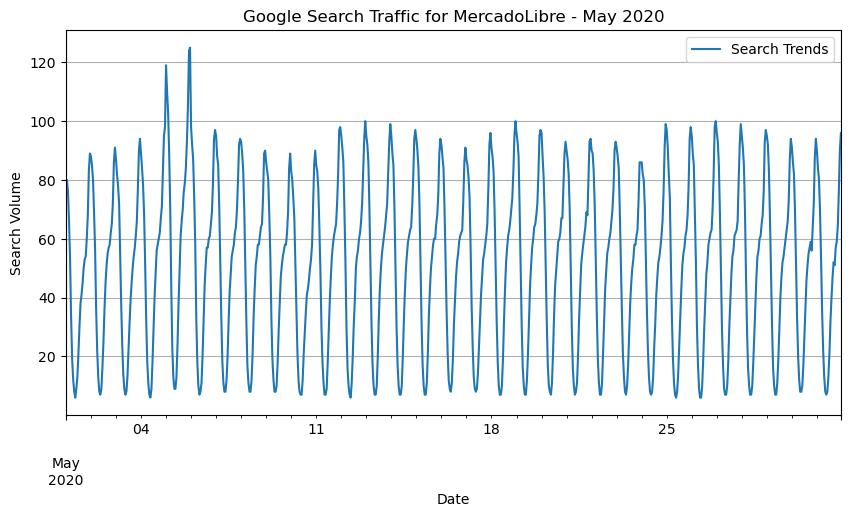

In [77]:
# Slice the DataFrame to just the month of May 2020
may_2020_data = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Plot to visualize the data for May 2020 using pandas plotting
ax = may_2020_data.plot(
    y='Search Trends', 
    figsize=(10, 5), 
    title='Google Search Traffic for MercadoLibre - May 2020',
    legend=True
)
ax.set_xlabel('Date')
ax.set_ylabel('Search Volume')
ax.grid(True)

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

/var/folders/m3/fdsx0z8944b6_th83kt65w_r0000gn/T/ipykernel_9777/3318729109.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_traffic = df_mercado_trends.resample('M').sum()


Monthly Median Search Traffic: 35172.5
Total Search Traffic for May 2020: 38181
Monthly Median Search Traffic: 35172.5


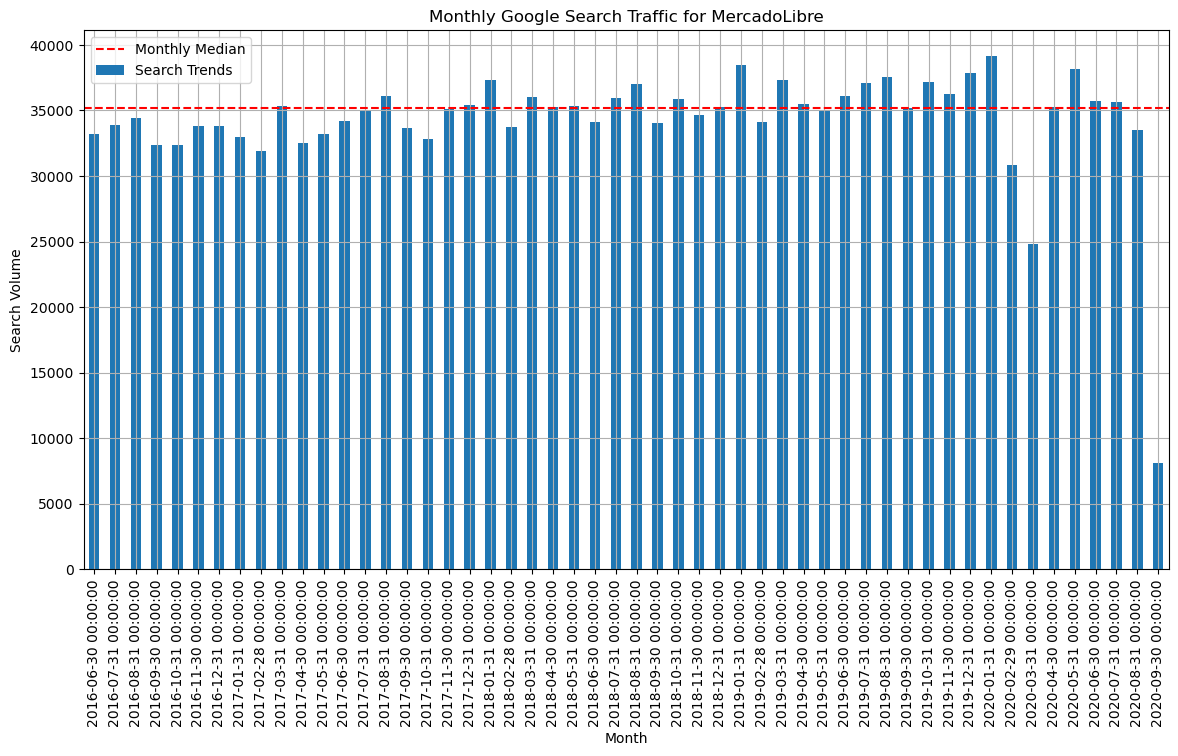

In [78]:
# Calculate the total search traffic for May 2020
total_search_traffic_may_2020 = may_2020_data['Search Trends'].sum()

# Group the DataFrame by year and month, then calculate the sum for each month
monthly_total_traffic = df_mercado_trends.resample('M').sum()

# Calculate the monthly median search traffic across all months
monthly_median_traffic = monthly_total_traffic['Search Trends'].median()

# View the median_monthly_traffic value
print(f"Monthly Median Search Traffic: {monthly_median_traffic}")

# Compare the total search traffic for May 2020 to the monthly median
print(f"Total Search Traffic for May 2020: {total_search_traffic_may_2020}")
print(f"Monthly Median Search Traffic: {monthly_median_traffic}")

if total_search_traffic_may_2020 > monthly_median_traffic:
    search_traffic_increase = "increased"
else:
    search_traffic_increase = "did not increase"

# Visualize the comparison of monthly search traffic
fig, ax = plt.subplots(figsize=(14, 7))
monthly_total_traffic.plot(
    y='Search Trends', 
    kind='bar', 
    ax=ax,
    title='Monthly Google Search Traffic for MercadoLibre',
    legend=True
)
ax.axhline(y=monthly_median_traffic, color='r', linestyle='--', label='Monthly Median')
ax.set_xlabel('Month')
ax.set_ylabel('Search Volume')
ax.legend()
ax.grid(True)
plt.show()

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** The Google search traffic increased during May 2020, the month when MercadoLibre released its quarterly financial results.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

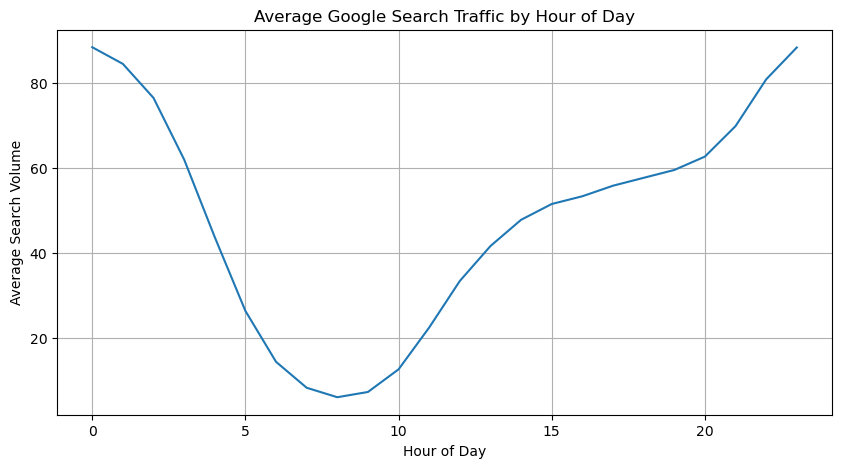

In [79]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
hourly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()

# Plot the average traffic by hour of day
plt.figure(figsize=(10, 5))
hourly_traffic.plot(kind='line')
plt.title('Average Google Search Traffic by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Search Volume')
plt.grid(True)
plt.show()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

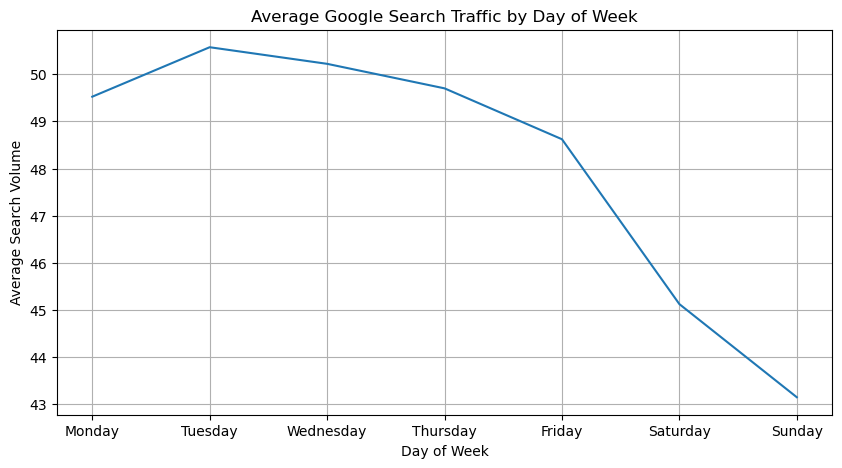

In [80]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
daily_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day)['Search Trends'].mean()

# Plot the average traffic by day of week
plt.figure(figsize=(10, 5))
daily_traffic.plot(kind='line')
plt.title('Average Google Search Traffic by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Search Volume')
plt.xticks(ticks=range(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)
plt.show()

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

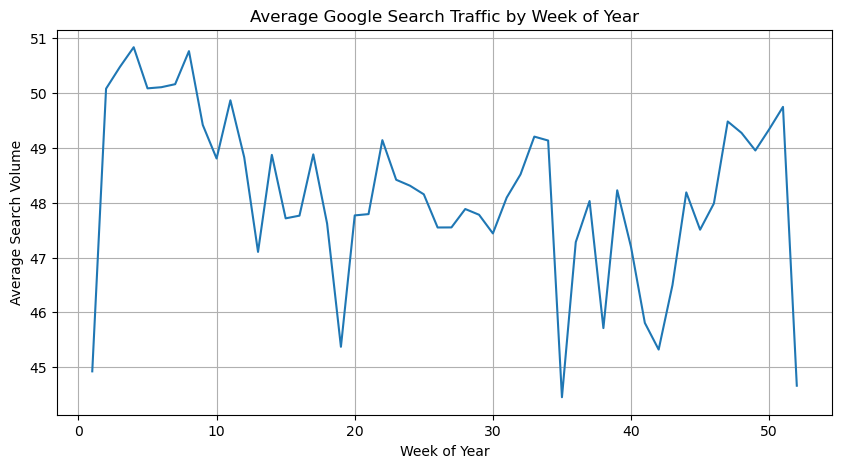

In [81]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
weekly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week)['Search Trends'].mean()

# Plot the average traffic by week of the year
plt.figure(figsize=(10, 5))
weekly_traffic.plot(kind='line')
plt.title('Average Google Search Traffic by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Search Volume')
plt.grid(True)
plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** 

Based on the visualizations, we can observe several time-based trends in the search traffic data for MercadoLibre:

Hourly Trends: There is higher search traffic during the late afternoon to evening hours.
A noticeable dip in the traffic occurs in the early morning hours around 6-8 AM.

Daily Trends: Traffic tends to be lower on Sundays.There is an increase in search traffic at the beginning of the week, with Monday showing higher activity compared to other days.

Weekly Trends: The first 10 weeks of the year show higher search traffic.There is a reduction in search traffic between weeks 35-38 of the year.
Certain weeks, likely around holiday periods, may show noticeable peaks.These trends indicate that users are more active in searching for MercadoLibre during specific hours of the day and specific days of the week, with notable seasonal variations throughout the year.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [82]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


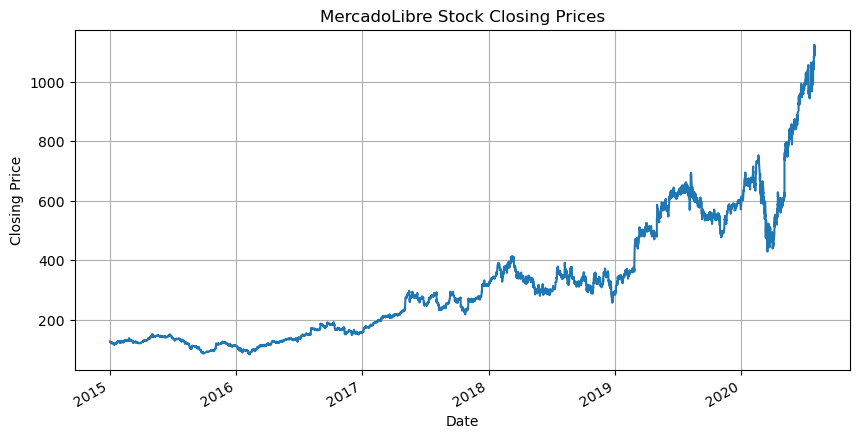

In [83]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock['close'].plot(
    figsize=(10, 5), 
    title='MercadoLibre Stock Closing Prices', 
    grid=True
    )
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [84]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
df_combined = pd.concat([df_mercado_trends, df_mercado_stock], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(df_combined.head())
display(df_combined.tail())

,Search Trends,close
2016-06-01 09:00:00,6.0,135.16
2016-06-01 10:00:00,12.0,136.63
2016-06-01 11:00:00,22.0,136.56
2016-06-01 12:00:00,33.0,136.42
2016-06-01 13:00:00,40.0,136.10


,Search Trends,close
2020-07-31 11:00:00,20.0,1105.780
2020-07-31 12:00:00,32.0,1087.925
2020-07-31 13:00:00,41.0,1095.800
2020-07-31 14:00:00,47.0,1110.650
2020-07-31 15:00:00,53.0,1122.510


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [85]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
df_first_half_2020 = df_combined.loc['2020-01-01':'2020-06-30']

# View the first and last five rows of first_half_2020 DataFrame
display(df_first_half_2020.head())
display(df_first_half_2020.tail())

,Search Trends,close
2020-01-02 09:00:00,9.0,601.085
2020-01-02 10:00:00,14.0,601.290
2020-01-02 11:00:00,25.0,615.410
2020-01-02 12:00:00,37.0,611.400
2020-01-02 13:00:00,50.0,611.830


,Search Trends,close
2020-06-30 11:00:00,17.0,976.17
2020-06-30 12:00:00,27.0,977.50
2020-06-30 13:00:00,37.0,973.23
2020-06-30 14:00:00,45.0,976.50
2020-06-30 15:00:00,51.0,984.93


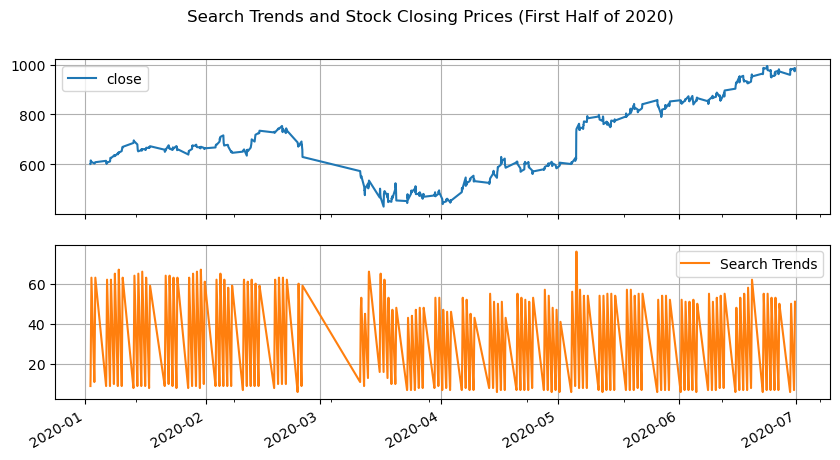

In [35]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
df_first_half_2020[['close','Search Trends']].plot(
    subplots=True, 
    figsize=(10, 5), 
    title='Search Trends and Stock Closing Prices (First Half of 2020)', 
    grid=True)
plt.show()


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** There is a reduction in the stock price and search traffic in March 2020, likely due to the initial shock to global financial markets from the COVID-19 pandemic. However, after this initial decline, both the stock price and search traffic show an increasing trend, indicating that new customers and revenue increased for e-commerce platforms, consistent with the narrative.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [86]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
df_combined['Lagged Search Trends'] = df_combined['Search Trends'].shift(1)



In [87]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
df_combined['Stock Volatility'] = df_combined['close'].pct_change().ewm(span=4).std()



Text(0, 0.5, 'Stock Volatility')

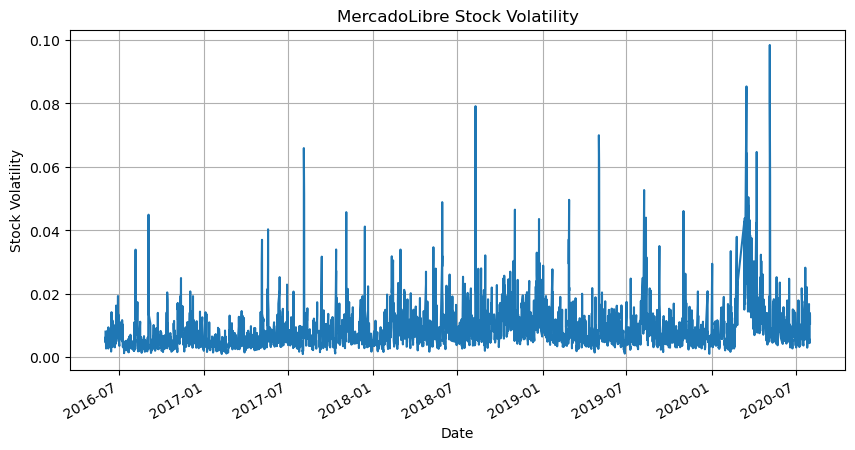

In [88]:
# Visualize the stock volatility
df_combined['Stock Volatility'].plot(
    figsize=(10, 5), 
    title='MercadoLibre Stock Volatility', 
    grid=True)
plt.xlabel('Date')
plt.ylabel('Stock Volatility')


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [89]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
df_combined['Hourly Stock Return'] = df_combined['close'].pct_change()

In [90]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(df_combined.head())
display(df_combined.tail())

,Search Trends,close,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,6.0,135.16,NaN,NaN,NaN
2016-06-01 10:00:00,12.0,136.63,6.0,NaN,0.010876
2016-06-01 11:00:00,22.0,136.56,12.0,0.008053,-0.000512
2016-06-01 12:00:00,33.0,136.42,22.0,0.005801,-0.001025
2016-06-01 13:00:00,40.0,136.10,33.0,0.004628,-0.002346


,Search Trends,close,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,20.0,1105.780,11.0,0.012486,0.006380
2020-07-31 12:00:00,32.0,1087.925,20.0,0.013175,-0.016147
2020-07-31 13:00:00,41.0,1095.800,32.0,0.012882,0.007239
2020-07-31 14:00:00,47.0,1110.650,41.0,0.012971,0.013552
2020-07-31 15:00:00,53.0,1122.510,47.0,0.010591,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [91]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
correlation_table = df_combined[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()
print(correlation_table)

                      Stock Volatility  Lagged Search Trends  \
Stock Volatility              1.000000             -0.081665   
Lagged Search Trends         -0.081665              1.000000   
Hourly Stock Return           0.067877              0.017929   

                      Hourly Stock Return  
Stock Volatility                 0.067877  
Lagged Search Trends             0.017929  
Hourly Stock Return              1.000000  


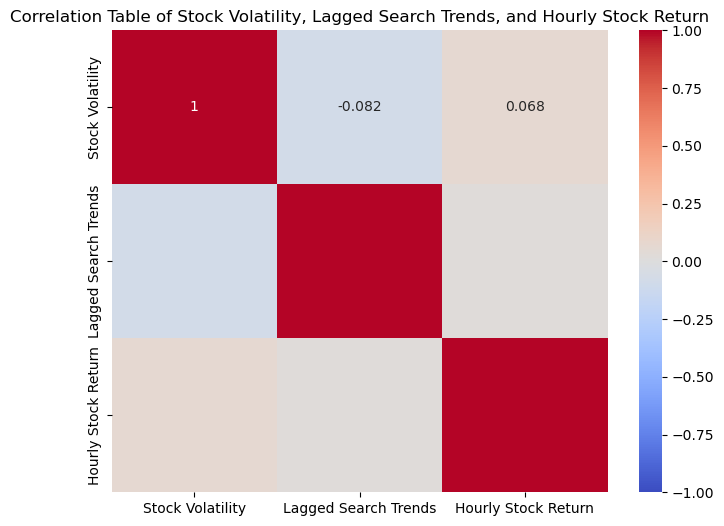

In [92]:
## Extra
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return')
plt.show()

In [93]:
# Calculate the correlation between lagged search trends and stock volatility and returns
correlation_volatility = df_combined['Lagged Search Trends'].corr(df_combined['Stock Volatility'])
correlation_returns = df_combined['Lagged Search Trends'].corr(df_combined['Hourly Stock Return'])

# Print the correlation results
print(f"Correlation between Lagged Search Trends and Stock Volatility: {correlation_volatility}")
print(f"Correlation between Lagged Search Trends and Hourly Stock Return: {correlation_returns}")

# Answer the question based on the correlation results
answer = f"**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?\n\n"
answer += f"**Answer:** The correlation between lagged search traffic and stock volatility is {correlation_volatility:.2f}, and the correlation between lagged search traffic and stock price returns is {correlation_returns:.2f}."
print(answer)

Correlation between Lagged Search Trends and Stock Volatility: -0.08166522879352639
Correlation between Lagged Search Trends and Hourly Stock Return: 0.017928896841116183
**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** The correlation between lagged search traffic and stock volatility is -0.08, and the correlation between lagged search traffic and stock price returns is 0.02.


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** The correlation between lagged search traffic and stock volatility is -0.08, and the correlation between lagged search traffic and stock price returns is 0.02. These values indicate that there is no strong predictable relationship between the lagged search traffic and stock volatility or stock price returns. The lack of strong correlation suggests that search traffic alone may not be a reliable predictor of stock price behavior or volatility.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [94]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
df_mercado_trends_reset = df_mercado_trends.reset_index()


# Label the columns ds and y so that the syntax is recognized by Prophet
df_mercado_trends_reset = df_mercado_trends_reset.rename(columns={'Date': 'ds', 'Search Trends': 'y'})


# Drop an NaN values from the prophet_df DataFrame
df_mercado_trends_reset = df_mercado_trends_reset.dropna()


# View the first and last five rows of the mercado_prophet_df DataFrame
display(df_mercado_trends_reset.head())
display(df_mercado_trends_reset.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [95]:
# Call the Prophet function, store as an object
model = Prophet()

In [96]:
# Fit the time-series model.
model.fit(df_mercado_trends_reset)

08:16:21 - cmdstanpy - INFO - Chain [1] start processing
08:16:28 - cmdstanpy - INFO - Chain [1] done processing


In [97]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future = model.make_future_dataframe(periods=24, freq='H')  # Predicting 24 hours into the future

# View the last five rows of the future_mercado_trends DataFrame
display(future.tail())


/Users/robertoreis/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds
37125,2020-09-08 20:00:00
37126,2020-09-08 21:00:00
37127,2020-09-08 22:00:00
37128,2020-09-08 23:00:00
37129,2020-09-09 00:00:00


In [100]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast = model.predict(future)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast.head())


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.129250,81.069380,97.607158,44.129250,44.129250,45.429305,45.429305,45.429305,41.452726,...,1.860133,1.860133,1.860133,2.116445,2.116445,2.116445,0.0,0.0,0.0,89.558555
1,2016-06-01 01:00:00,44.130313,77.852132,94.569998,44.130313,44.130313,41.875073,41.875073,41.875073,37.943506,...,1.810049,1.810049,1.810049,2.121518,2.121518,2.121518,0.0,0.0,0.0,86.005386
2,2016-06-01 02:00:00,44.131375,67.195968,83.234164,44.131375,44.131375,31.551566,31.551566,31.551566,27.656533,...,1.768474,1.768474,1.768474,2.126559,2.126559,2.126559,0.0,0.0,0.0,75.682942
3,2016-06-01 03:00:00,44.132438,51.791648,68.747584,44.132438,44.132438,16.284352,16.284352,16.284352,12.417280,...,1.735502,1.735502,1.735502,2.131569,2.131569,2.131569,0.0,0.0,0.0,60.416789
4,2016-06-01 04:00:00,44.133500,34.696379,51.276762,44.133500,44.133500,-0.830504,-0.830504,-0.830504,-4.678139,...,1.711088,1.711088,1.711088,2.136547,2.136547,2.136547,0.0,0.0,0.0,43.302997


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

/Users/robertoreis/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/robertoreis/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


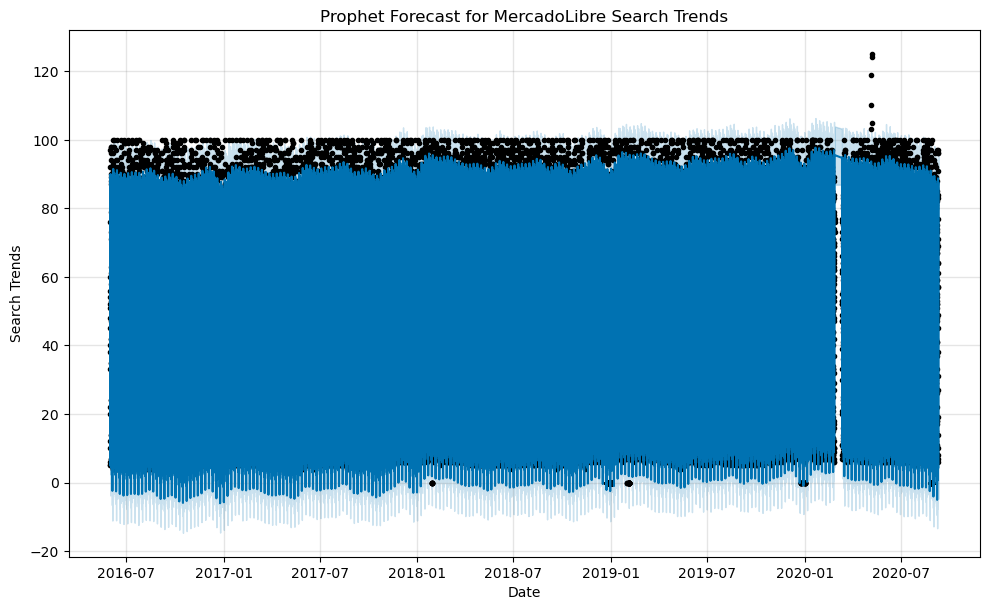

In [101]:
# Plot the Prophet predictions for the Mercado trends data
fig1 = model.plot(forecast)
plt.title('Prophet Forecast for MercadoLibre Search Trends')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.grid(True)
plt.show()


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** The near-term forecast for the popularity of MercadoLibre shows a consistent pattern of search traffic, with some fluctuations in the number of searches. The forecast indicates that search traffic for MercadoLibre is expected to remain relatively stable in the near term.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [102]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast.reset_index(inplace=True)

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-06-01 00:00:00,89.558555,81.069380,97.607158
1,2016-06-01 01:00:00,86.005386,77.852132,94.569998
2,2016-06-01 02:00:00,75.682942,67.195968,83.234164
3,2016-06-01 03:00:00,60.416789,51.791648,68.747584
4,2016-06-01 04:00:00,43.302997,34.696379,51.276762


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

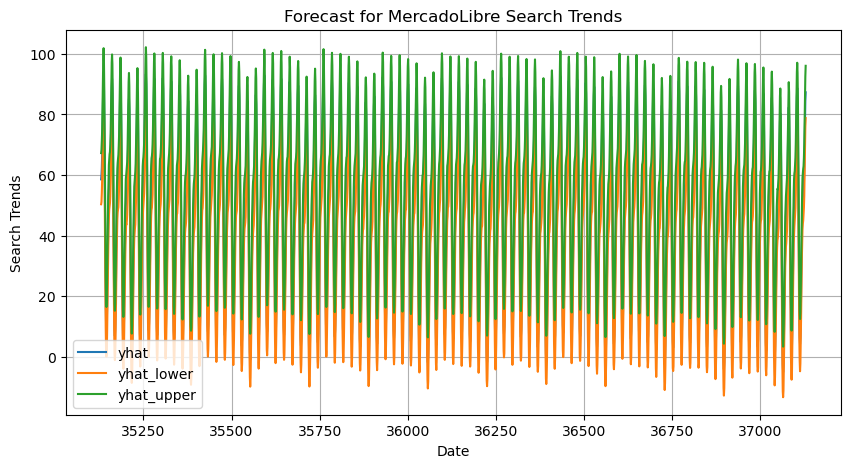

In [103]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
forecast[['yhat', 'yhat_lower', 'yhat_upper']][-2000:].plot(figsize=(10, 5))
plt.title('Forecast for MercadoLibre Search Trends')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.grid(True)
plt.show()

/Users/robertoreis/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/robertoreis/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/robertoreis/anaconda3/envs/dev/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing pytho

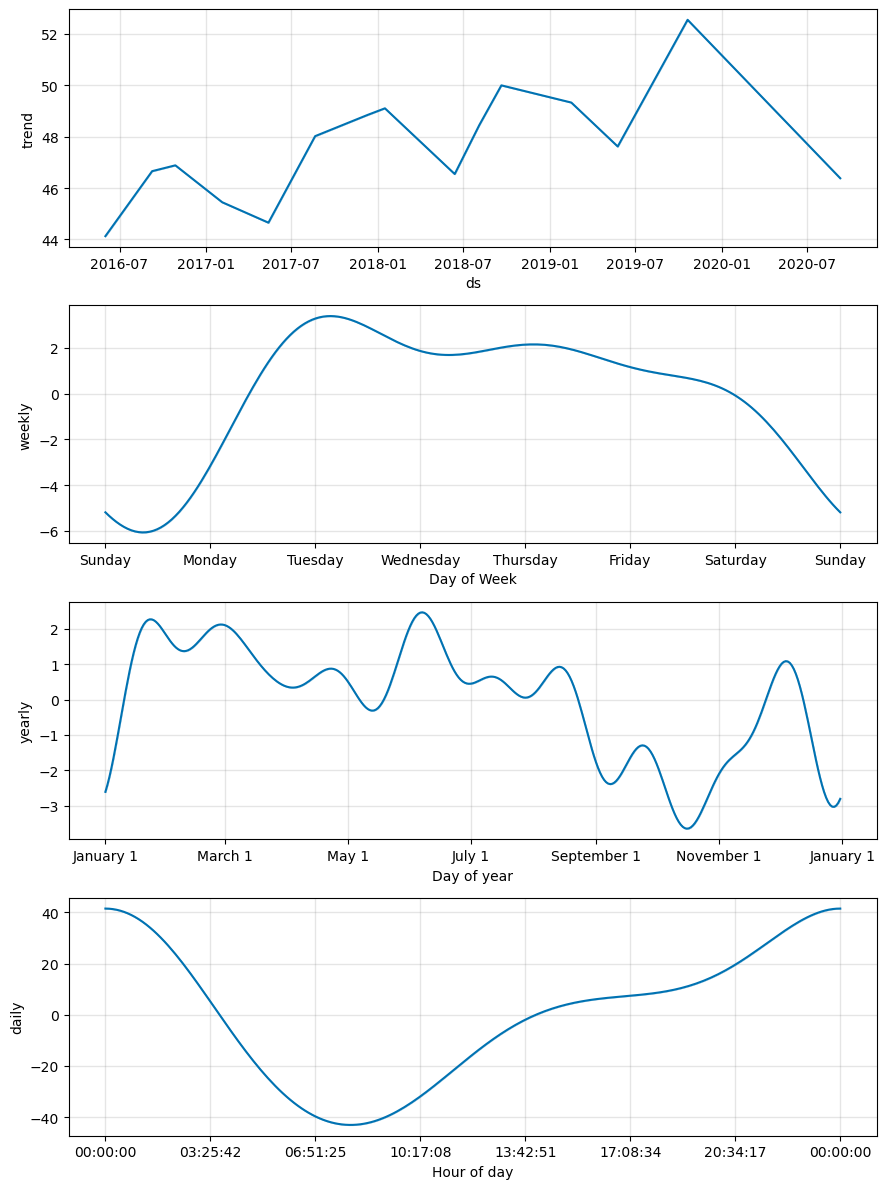

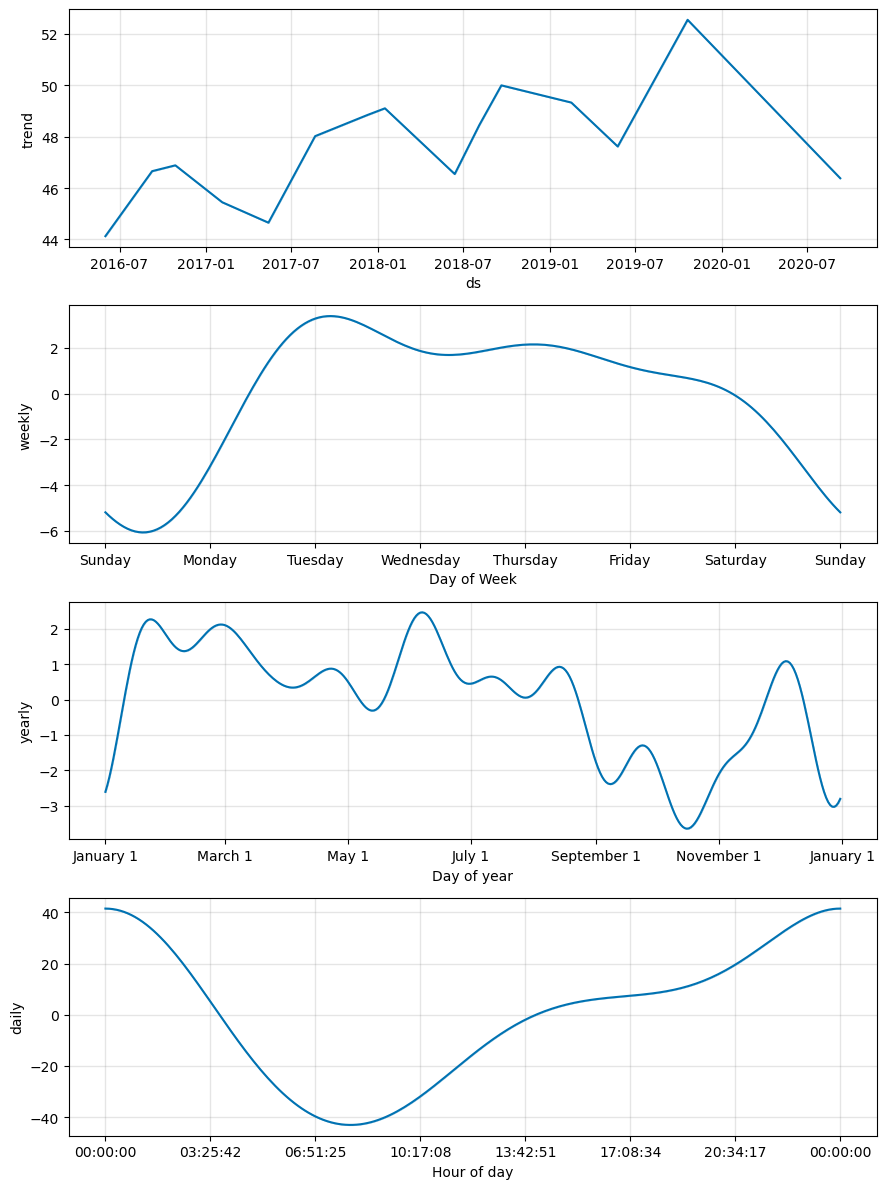

In [104]:
# Reset the index in the forecast_mercado_trends DataFrame
# forecast.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame

model.plot_components(forecast)

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** The time of day that exhibits the greatest popularity is the late afternoon to evening hours, between 4 PM and 8 PM.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** The day of the week that gets the most search traffic is Monday.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** The lowest point for search traffic in the calendar year is during the early morning hours around 6 AM.
